# See extensionPlanReport.pdf
Find various health issues that are relevant to smoke (cardiovascular and respiratory issues).  
Get national averages.  
Find smoke impact to those issues and see how much it increases risk of them.  
Add average for city population + percentage risk increase * leftover pop to get projected new numbers of disease in the city
Find estimate for total ED visits via relevant diseases (percentages based on number of people with specific diseases relevant to smoke).  
Once we get yearly estimates do a linear regression/ARMA to project to 2050.  
Project the rest of the diseases for visualizations.  
Lets try to model total emergency department visits  

Try to see how ED visits is proportional to number of workers in healthcare?  

# Imports

In [1]:
import os, json, time, sys
from wildfire.Reader import Reader
#import geojson
import requests
#import pyproj
import math
import numpy as np
import datetime as dt
#from pyproj import Transformer, Geod
from wildfire.Reader import Reader as WFReader
from tqdm import tqdm
import sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
import statsmodels
import statsmodels.api as sm
import csv
import pandas as pd

# Read in census data

#### Age demographics per year from 2010-2021
Codes:  
S0101_C01_001E - Total population estimate  
S0101_C01_002E - Age under 5 estimate  
S0101_C01_003E - Age 5 to 9 estimate  
S0101_C01_004E - Age 10 to 14 estimate  
S0101_C01_005E - Age 15 to 19 estimate  
S0101_C01_006E - 20 to 24  
S0101_C01_007E - 25 to 29  
S0101_C01_008E - 30 to 34  
S0101_C01_009E - 35 to 39  
S0101_C01_010E - 40 to 44  
S0101_C01_011E - 45 to 49  
S0101_C01_012E - 50 to 54  
S0101_C01_013E - 55 to 59  
S0101_C01_014E - 60 to 64  
S0101_C01_015E - 65 to 69  
S0101_C01_016E - 70 to 74  
S0101_C01_017E - 75 to 79  
S0101_C01_018E - 80 to 84  
S0101_C01_019E - 85+  
S0101_C01_032E - Age depedency ratio

In [15]:
def getAgeInformation(filepath):
    """
    Description:
        Reads in census data age files and parses out particular fields we care about.
        See above markdown cell for code information.
    Inputs:
        filepath - String - Location of file
    Outputs:
        Dictionary
    """
    results = {}
    testdf = pd.read_csv(filepath)
    Total_pop_estimate = float(testdf['S0101_C01_001E'][1])
    results["Total_pop_estimate"] = Total_pop_estimate
    results["Pop_estimate_0to5"] = float(testdf['S0101_C01_002E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_5to9"] = float(testdf['S0101_C01_003E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_10to14"] = float(testdf['S0101_C01_004E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_15to19"] = float(testdf['S0101_C01_005E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_20to24"] = float(testdf['S0101_C01_006E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_25to29"] = float(testdf['S0101_C01_007E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_30to34"] = float(testdf['S0101_C01_008E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_35to39"] = float(testdf['S0101_C01_009E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_40to44"] = float(testdf['S0101_C01_010E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_45to49"] = float(testdf['S0101_C01_011E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_50to54"] = float(testdf['S0101_C01_012E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_55to59"] = float(testdf['S0101_C01_013E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_60to64"] = float(testdf['S0101_C01_014E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_65to69"] = float(testdf['S0101_C01_015E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_70to74"] = float(testdf['S0101_C01_016E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_75to79"] = float(testdf['S0101_C01_017E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_80to84"] = float(testdf['S0101_C01_018E'][1]) * Total_pop_estimate/100
    results["Pop_estimate_85toINF"] = float(testdf['S0101_C01_019E'][1]) * Total_pop_estimate/100
    results["Age_dependency_ratio"] = float(testdf['S0101_C01_032E'][1])
    return results

PopulationInfo = {
    "2010" : getAgeInformation("../Data/AgeAndSex/ACSST5Y2010.S0101-Data.csv"),
    "2011" : getAgeInformation("../Data/AgeAndSex/ACSST5Y2011.S0101-Data.csv"),
    "2012" : getAgeInformation("../Data/AgeAndSex/ACSST5Y2012.S0101-Data.csv"),
    "2013" : getAgeInformation("../Data/AgeAndSex/ACSST5Y2013.S0101-Data.csv"),
    "2014" : getAgeInformation("../Data/AgeAndSex/ACSST5Y2014.S0101-Data.csv"),
    "2015" : getAgeInformation("../Data/AgeAndSex/ACSST5Y2015.S0101-Data.csv"),
    "2016" : getAgeInformation("../Data/AgeAndSex/ACSST5Y2016.S0101-Data.csv"),
    "2017" : getAgeInformation("../Data/AgeAndSex/ACSST5Y2017.S0101-Data.csv"),
    "2018" : getAgeInformation("../Data/AgeAndSex/ACSST5Y2018.S0101-Data.csv"),
    "2019" : getAgeInformation("../Data/AgeAndSex/ACSST5Y2019.S0101-Data.csv"),
    "2020" : getAgeInformation("../Data/AgeAndSex/ACSST5Y2020.S0101-Data.csv"),
    "2021" : getAgeInformation("../Data/AgeAndSex/ACSST5Y2021.S0101-Data.csv")
}
print(PopulationInfo["2012"])

{'Total_pop_estimate': 35434.0, 'Pop_estimate_0to5': 2941.022, 'Pop_estimate_5to9': 2409.5119999999997, 'Pop_estimate_10to14': 2586.682, 'Pop_estimate_15to19': 2090.606, 'Pop_estimate_20to24': 2232.3419999999996, 'Pop_estimate_25to29': 2374.078, 'Pop_estimate_30to34': 3153.626, 'Pop_estimate_35to39': 2976.456, 'Pop_estimate_40to44': 2409.5119999999997, 'Pop_estimate_45to49': 2480.38, 'Pop_estimate_50to54': 2338.644, 'Pop_estimate_55to59': 2232.3419999999996, 'Pop_estimate_60to64': 1488.228, 'Pop_estimate_65to69': 1346.4919999999997, 'Pop_estimate_70to74': 814.982, 'Pop_estimate_75to79': 460.64200000000005, 'Pop_estimate_80to84': 566.944, 'Pop_estimate_85toINF': 566.944, 'Age_dependency_ratio': 57.7}


#### Industry by employed civilian over 16
Codes: 
S2407_C01_001E - Total estimate civilian employed population 16+  
S2407_C01_011E - Total estimate Educational/Healthcare/social workers

In [3]:
def getEmploymentInformation(filepath):
    """
    Description:
        Reads in census data employment files and parses out particular fields we care about.
        See above markdown cell for code information.
    Inputs:
        filepath - String - Location of file
    Outputs:
        Dictionary
    """
    results = {}
    testdf = pd.read_csv(filepath)
    Total_pop_estimate = float(testdf['S2407_C01_001E'][1])
    results["Total_estimate_employed"] = Total_pop_estimate
    results["Employed_estimate_healthcare_education_socialworkers"] = float(testdf['S2407_C01_011E'][1])
    return results

EmploymentInfo = {
    "2010" :  getEmploymentInformation("../Data/IndustryByClassCivilianEmployedOver16/ACSST5Y2010.S2407-Data.csv"),
    "2011" :  getEmploymentInformation("../Data/IndustryByClassCivilianEmployedOver16/ACSST5Y2011.S2407-Data.csv"),
    "2012" :  getEmploymentInformation("../Data/IndustryByClassCivilianEmployedOver16/ACSST5Y2012.S2407-Data.csv"),
    "2013" :  getEmploymentInformation("../Data/IndustryByClassCivilianEmployedOver16/ACSST5Y2013.S2407-Data.csv"),
    "2014" :  getEmploymentInformation("../Data/IndustryByClassCivilianEmployedOver16/ACSST5Y2014.S2407-Data.csv"),
    "2015" :  getEmploymentInformation("../Data/IndustryByClassCivilianEmployedOver16/ACSST5Y2015.S2407-Data.csv"),
    "2016" :  getEmploymentInformation("../Data/IndustryByClassCivilianEmployedOver16/ACSST5Y2016.S2407-Data.csv"),
    "2017" :  getEmploymentInformation("../Data/IndustryByClassCivilianEmployedOver16/ACSST5Y2017.S2407-Data.csv"),
    "2018" :  getEmploymentInformation("../Data/IndustryByClassCivilianEmployedOver16/ACSST5Y2018.S2407-Data.csv"),
    "2019" :  getEmploymentInformation("../Data/IndustryByClassCivilianEmployedOver16/ACSST5Y2019.S2407-Data.csv"),
    "2020" :  getEmploymentInformation("../Data/IndustryByClassCivilianEmployedOver16/ACSST5Y2020.S2407-Data.csv"),
    "2021" :  getEmploymentInformation("../Data/IndustryByClassCivilianEmployedOver16/ACSST5Y2021.S2407-Data.csv")
}
print(EmploymentInfo["2010"])

{'Total_estimate_employed': 12739.0, 'Employed_estimate_healthcare_education_socialworkers': 2898.0}


# Basic visualizations

#### Population over time

Text(0, 0.5, 'Population count')

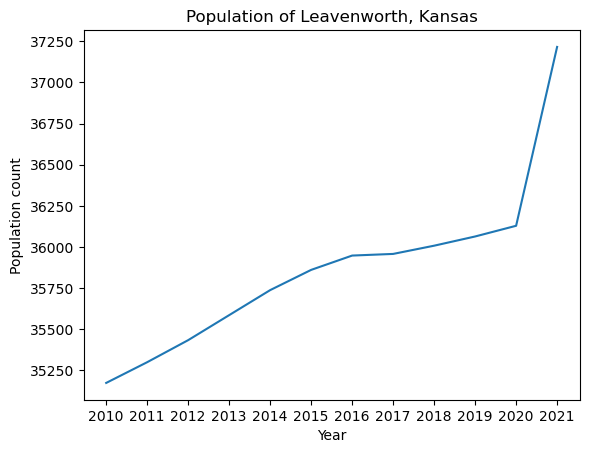

In [4]:
# Get information into format that is digestible by matplotlib
population_estimates = []
years = []
for year in PopulationInfo.keys():
    years.append(year)
    population_estimates.append(PopulationInfo[year]['Total_pop_estimate'])

# Create plot
plt.plot(years, population_estimates)
plt.title("Population of Leavenworth, Kansas")
plt.xlabel("Year")
plt.ylabel("Population count")

#### Health care employment percentage to overal population

Text(42.597222222222214, 0.5, 'Population count')

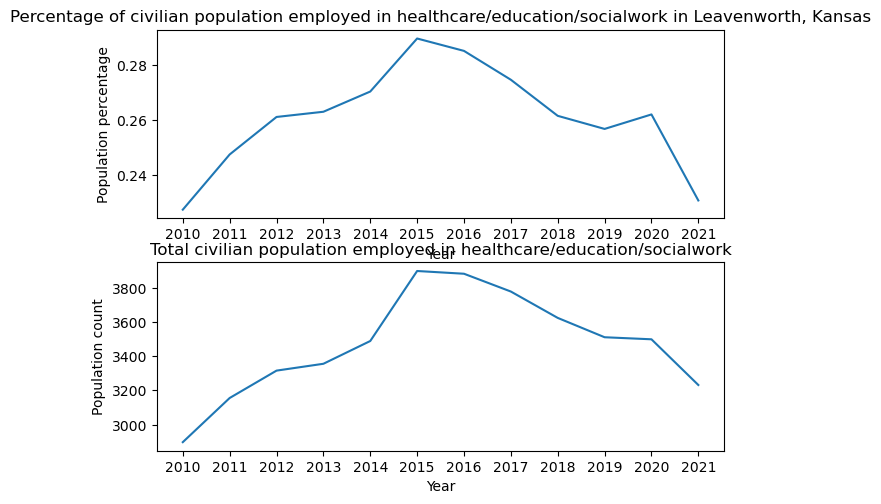

In [5]:
healthcare_employment_percentages = []
healthcare_employment_totals = []
years = []
for year in EmploymentInfo.keys():
    years.append(year)
    healthcare_employment_totals.append(EmploymentInfo[year]['Employed_estimate_healthcare_education_socialworkers'])
    healthcare_employment_percentages.append(EmploymentInfo[year]['Employed_estimate_healthcare_education_socialworkers'] / EmploymentInfo[year]['Total_estimate_employed'])

# Create plots
fig, ax = plt.subplots(2,1)
fig.tight_layout()
ax[0].plot(years, healthcare_employment_percentages)
ax[0].set_title("Percentage of civilian population employed in healthcare/education/socialwork in Leavenworth, Kansas")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Population percentage")

ax[1].plot(years, healthcare_employment_totals)
ax[1].set_title("Total civilian population employed in healthcare/education/socialwork")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Population count")

#### Age dependency ratio

Text(0, 0.5, 'Age dependency ratio')

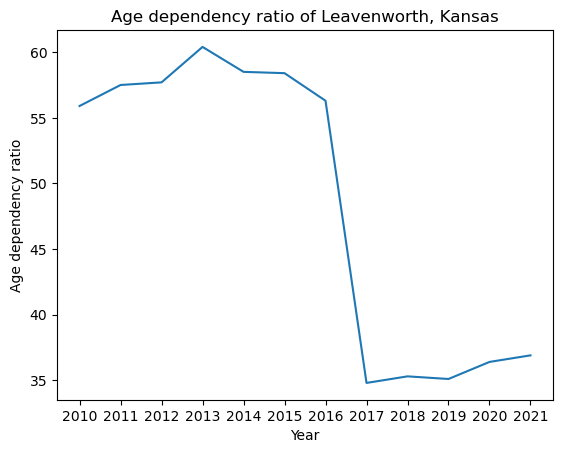

In [17]:
# Get information into format that is digestible by matplotlib
ADRs = []
years = []
for year in PopulationInfo.keys():
    years.append(year)
    ADRs.append(PopulationInfo[year]['Age_dependency_ratio'])

# Create plot
plt.plot(years, ADRs)
plt.title("Age dependency ratio of Leavenworth, Kansas")
plt.xlabel("Year")
plt.ylabel("Age dependency ratio")

#### Health insurance

In [ ]:
asd

# Project leavenworth population to 2050
Using a simple line equation, Population = ((36129-35174)/11)x + 35174, where x is the number of years after 2010  
We are ignoring 2021 population in this case since it looks a bit anomalous

Text(0, 0.5, 'Population count')

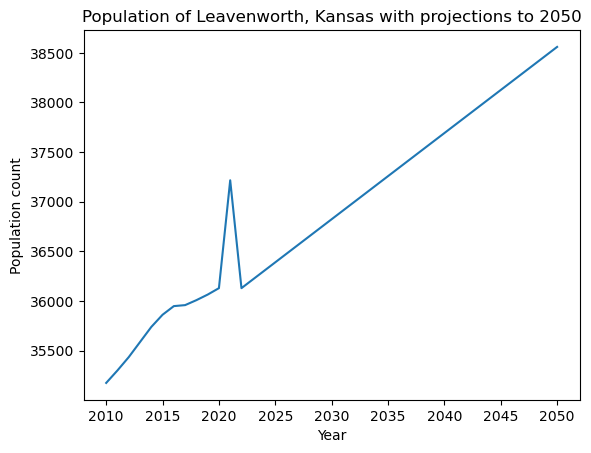

In [6]:
population_estimates_with_projections = []
years_with_projections = []

#put in old data
for i in range(len(years)):
    years_with_projections.append(int(years[i]))
    population_estimates_with_projections.append(population_estimates[i])

# put in projected data
for i in range(11, 40):
    projected_pop = (((36129-35174)/11) * i) + 35174
    population_estimates_with_projections.append(projected_pop)
    years_with_projections.append(int(2011 + i))

# Create plot
plt.plot(years_with_projections, population_estimates_with_projections)
plt.title("Population of Leavenworth, Kansas with projections to 2050")
plt.xlabel("Year")
plt.ylabel("Population count")

# Estimate Leavenworth population with relevant smoke-related health conditions based on national averages (Assuming AQI of 0)

#### Asthma
According to, https://www.cdc.gov/asthma/most_recent_national_asthma_data.htm 7.7% of people in the US had asthma in 2021.

In [7]:
AsthmaInfo = {}
for i in range(len(population_estimates_with_projections)):
    AsthmaInfo[2010+i] = population_estimates_with_projections[i] * 0.077
print(AsthmaInfo)

{2010: 2708.398, 2011: 2718.1, 2012: 2728.418, 2013: 2740.122, 2014: 2751.826, 2015: 2761.297, 2016: 2767.996, 2017: 2768.766, 2018: 2772.616, 2019: 2776.928, 2020: 2781.933, 2021: 2865.632, 2022: 2781.933, 2023: 2788.618, 2024: 2795.303, 2025: 2801.988, 2026: 2808.6730000000002, 2027: 2815.358, 2028: 2822.0429999999997, 2029: 2828.728, 2030: 2835.413, 2031: 2842.0980000000004, 2032: 2848.783, 2033: 2855.468, 2034: 2862.1530000000002, 2035: 2868.8379999999997, 2036: 2875.5229999999997, 2037: 2882.208, 2038: 2888.893, 2039: 2895.578, 2040: 2902.263, 2041: 2908.948, 2042: 2915.633, 2043: 2922.3179999999998, 2044: 2929.003, 2045: 2935.688, 2046: 2942.3729999999996, 2047: 2949.058, 2048: 2955.743, 2049: 2962.4280000000003, 2050: 2969.113}


#### Cardiovascular disease (CVD)
According to, https://professional.heart.org/-/media/PHD-Files-2/Science-News/2/2022-Heart-and-Stroke-Stat-Update/2022-Stat-Update-factsheet-GIobal-Burden-of-Disease.pdf 7534.1 per 100000 people have CVD.

In [8]:
CVDInfo = {}
for i in range(len(population_estimates_with_projections)):
    CVDInfo[2010+i] = (population_estimates_with_projections[i] * 7534.1) / 100000
print(CVDInfo)

{2010: 2650.044334, 2011: 2659.5373, 2012: 2669.632994, 2013: 2681.0848260000002, 2014: 2692.536658, 2015: 2701.803601, 2016: 2708.358268, 2017: 2709.111678, 2018: 2712.878728, 2019: 2717.0978240000004, 2020: 2721.9949890000003, 2021: 2803.890656, 2022: 2721.9949890000003, 2023: 2728.535957636364, 2024: 2735.076926272727, 2025: 2741.617894909091, 2026: 2748.1588635454546, 2027: 2754.6998321818187, 2028: 2761.2408008181815, 2029: 2767.781769454545, 2030: 2774.3227380909093, 2031: 2780.863706727273, 2032: 2787.4046753636367, 2033: 2793.9456440000004, 2034: 2800.486612636364, 2035: 2807.0275812727273, 2036: 2813.568549909091, 2037: 2820.1095185454546, 2038: 2826.6504871818183, 2039: 2833.1914558181816, 2040: 2839.7324244545453, 2041: 2846.273393090909, 2042: 2852.814361727272, 2043: 2859.3553303636368, 2044: 2865.8962990000005, 2045: 2872.437267636364, 2046: 2878.9782362727274, 2047: 2885.519204909091, 2048: 2892.0601735454547, 2049: 2898.6011421818184, 2050: 2905.1421108181817}


#### Chronic Obstructive Pulmonary Disease (COPD)
According to https://www.cdc.gov/copd/basics-about.html#:~:text=Chronic%20lower%20respiratory%20disease%2C%20primarily,the%20United%20States%20in%202018.&text=Almost%2015.7%20million%20Americans%20, 6.4 percent of people have COPD circa 2018

In [9]:
COPDInfo = {}
for i in range(len(population_estimates_with_projections)):
    COPDInfo[2010+i] = population_estimates_with_projections[i] * 0.064
print(COPDInfo)

{2010: 2251.136, 2011: 2259.2000000000003, 2012: 2267.776, 2013: 2277.504, 2014: 2287.232, 2015: 2295.1040000000003, 2016: 2300.672, 2017: 2301.312, 2018: 2304.512, 2019: 2308.096, 2020: 2312.256, 2021: 2381.824, 2022: 2312.256, 2023: 2317.812363636364, 2024: 2323.368727272727, 2025: 2328.925090909091, 2026: 2334.4814545454547, 2027: 2340.0378181818182, 2028: 2345.594181818182, 2029: 2351.1505454545454, 2030: 2356.7069090909094, 2031: 2362.263272727273, 2032: 2367.819636363636, 2033: 2373.376, 2034: 2378.932363636364, 2035: 2384.488727272727, 2036: 2390.045090909091, 2037: 2395.6014545454545, 2038: 2401.1578181818186, 2039: 2406.7141818181817, 2040: 2412.2705454545453, 2041: 2417.8269090909093, 2042: 2423.3832727272725, 2043: 2428.9396363636365, 2044: 2434.496, 2045: 2440.0523636363637, 2046: 2445.6087272727273, 2047: 2451.165090909091, 2048: 2456.7214545454544, 2049: 2462.2778181818185, 2050: 2467.8341818181816}


#### Heart attack (myocardial infarction - MI)
According to https://www.cdc.gov/heartdisease/facts.htm, 805k americans experience a heart attack per year.  
According to https://www.census.gov/library/stories/2022/12/happy-new-year-2023.html#:~:text=Related%20Statistics&text=The%20U.S.%20Census%20Bureau%20projects%20the%20U.S.%20population%20will%20be,1%2C%202022., the us population was 334,233,854 circa Jan 1, 2023. This means we will estimate that 805000/334,233,854 = 0.241% of people experience a heart attack per year

In [10]:
HeartAttackInfo = {}
for i in range(len(population_estimates_with_projections)):
    HeartAttackInfo[2010+i] = population_estimates_with_projections[i] * 0.00241
print(HeartAttackInfo)

{2010: 84.76934, 2011: 85.073, 2012: 85.39594, 2013: 85.76226, 2014: 86.12858, 2015: 86.42501, 2016: 86.63467999999999, 2017: 86.65878, 2018: 86.77928, 2019: 86.91423999999999, 2020: 87.07088999999999, 2021: 89.69055999999999, 2022: 87.07088999999999, 2023: 87.28012181818181, 2024: 87.48935363636362, 2025: 87.69858545454545, 2026: 87.90781727272727, 2027: 88.11704909090909, 2028: 88.3262809090909, 2029: 88.53551272727272, 2030: 88.74474454545454, 2031: 88.95397636363637, 2032: 89.16320818181816, 2033: 89.37244, 2034: 89.58167181818182, 2035: 89.79090363636362, 2036: 90.00013545454544, 2037: 90.20936727272726, 2038: 90.41859909090908, 2039: 90.62783090909089, 2040: 90.83706272727272, 2041: 91.04629454545454, 2042: 91.25552636363635, 2043: 91.46475818181817, 2044: 91.67398999999999, 2045: 91.88322181818181, 2046: 92.09245363636362, 2047: 92.30168545454545, 2048: 92.51091727272727, 2049: 92.72014909090909, 2050: 92.9293809090909}


#### Stroke
According to https://www.cdc.gov/stroke/facts.htm, 795000 Americans experience a stroke per year
 This means we will estimate that 795000/334,233,854 = 0.237% of people experience a heart attack per year

In [11]:
StrokeInfo = {}
for i in range(len(population_estimates_with_projections)):
    StrokeInfo[2010+i] = population_estimates_with_projections[i] * 0.00237
print(StrokeInfo)

{2010: 83.36238, 2011: 83.661, 2012: 83.97858000000001, 2013: 84.33882, 2014: 84.69906, 2015: 84.99057, 2016: 85.19676000000001, 2017: 85.22046, 2018: 85.33896, 2019: 85.47168, 2020: 85.62573, 2021: 88.20192, 2022: 85.62573, 2023: 85.8314890909091, 2024: 86.03724818181819, 2025: 86.24300727272727, 2026: 86.44876636363637, 2027: 86.65452545454546, 2028: 86.86028454545455, 2029: 87.06604363636364, 2030: 87.27180272727274, 2031: 87.47756181818183, 2032: 87.68332090909091, 2033: 87.88908, 2034: 88.0948390909091, 2035: 88.30059818181817, 2036: 88.50635727272727, 2037: 88.71211636363637, 2038: 88.91787545454547, 2039: 89.12363454545455, 2040: 89.32939363636363, 2041: 89.53515272727273, 2042: 89.74091181818181, 2043: 89.94667090909091, 2044: 90.15243000000001, 2045: 90.35818909090911, 2046: 90.56394818181818, 2047: 90.76970727272727, 2048: 90.97546636363637, 2049: 91.18122545454547, 2050: 91.38698454545454}


# Get number of estimated ED visits using population counts
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8862306/ - Asthma is 1.3% of ED visits  
https://www.cdc.gov/mmwr/volumes/67/wr/mm6713a1.htm 9.9% of people with asthma visited ED  
https://www.cdc.gov/nchs/data/nhsr/nhsr174.pdf 11.4% ED visits from heart disease (CVD)    
https://journal.copdfoundation.org/jcopdf/id/1103/Characteristics-of-COPD-Patients-Using-United-States-Emergency-Care-or-Hospitalization#:~:text=Results%3A%20Among%20diagnosed%20COPD%20patients,hospitalization%20in%20the%20previous%20year. COPD patients 16.3% ED visit  
https://hcup-us.ahrq.gov/reports/statbriefs/sb47.pdf 0.6% of ED visits are for Heart attack, 0.6% are for stroke
https://www.cdc.gov/nchs/products/databriefs/db452.htm#:~:text=An%20estimated%20131%20million%20ED,with%20all%20other%20age%20groups. 40/100 people visit ED each year 

In [12]:
# General visits to ED each year is 40/100 people
ED_visits_no_smoke = {}
for i in range(len(population_estimates_with_projections)):
    year = 2010 + i
    total_ED_visits = population_estimates_with_projections[i] * 0.4
    ED_visits_no_smoke[year] = {
        "total" : total_ED_visits,
        "Asthma": total_ED_visits * 0.013,
        "CVD": total_ED_visits * 0.114,
        "COPD": COPDInfo[year] * 0.163,
        "Heart_attack": total_ED_visits * 0.061, #So we can see it on the plot...
        "Stroke": total_ED_visits * 0.06,
    }

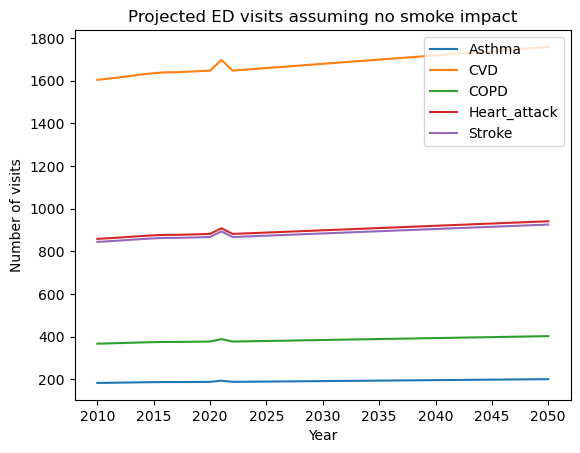

In [13]:
years = []
Totals = []
Asthma = []
CVD = []
COPD = []
Heart_attack = []
Stroke = []
for year in ED_visits_no_smoke.keys():
    years.append(year)
    Totals.append(ED_visits_no_smoke[year]["total"])
    Asthma.append(ED_visits_no_smoke[year]["Asthma"])
    CVD.append(ED_visits_no_smoke[year]["CVD"])
    COPD.append(ED_visits_no_smoke[year]["COPD"])
    Heart_attack.append(ED_visits_no_smoke[year]["Heart_attack"])
    Stroke.append(ED_visits_no_smoke[year]["Stroke"])

#plt.plot(years, Totals, label="Total")
plt.plot(years, Asthma, label="Asthma")
plt.plot(years, CVD, label="CVD")
plt.plot(years, COPD, label="COPD")
plt.plot(years, Heart_attack, label="Heart_attack")
plt.plot(years, Stroke, label="Stroke")
plt.title("Projected ED visits assuming no smoke impact")
plt.xlabel("Year")
plt.ylabel("Number of visits")
plt.legend()

# Get smoke estimates from previous notebook

In [14]:
with open('../Data/SmokeEstimates.json') as json_file:
    yearly_smoke_estimates = json.load(json_file)
print(yearly_smoke_estimates)

{'1963': 0.0007845067778975681, '1964': 0.0021635518913411113, '1965': 0.016998440407767827, '1966': 0.001709264752936373, '1967': 0.0007258876689639057, '1968': 0.00023524296902009573, '1969': 0.00042468012485909315, '1970': 0.01636269377142011, '1971': 0.004964268863689638, '1972': 0.0645188233004377, '1973': 0.0028017974332351986, '1974': 0.005278419103684302, '1975': 0.003068875009681437, '1976': 0.009844000320371735, '1977': 0.005877137870063218, '1978': 0.0028136060770111815, '1979': 0.004597308611750616, '1980': 0.00903175447855878, '1981': 0.00626256943128422, '1982': 0.002182304839698396, '1983': 0.003428670487791997, '1984': 0.05052999156470137, '1985': 0.023711393443061515, '1986': 0.3995515686962825, '1987': 6.747426608874581, '1988': 62.1655596660853, '1989': 0.6703940050932565, '1990': 0.5803287878283707, '1991': 13.852136642471152, '1992': 0.39384184550046947, '1993': 9.943104784949654, '1994': 20.334484426133606, '1995': 7.444358712848471, '1996': 53.120512342635934, '1

# Estimate increase in ED visits from the smoke information
Yearly smoke formula: Smoke_impact_from_fire = (area_forest_burned * 10 * 87.5) / (distance_from_city^5) To get the annual smoke estimate, we sum the smoke_impact_from_fire over every fire

Since we are unsure of the relative scale of our smoke estimate, we will simply use 1000 as the full multiplier from the studies and 0 as a 1.0 multiplier 

https://usafacts.org/articles/how-many-wildfires-occur-in-the-us/ 119 acres for avg fire  
https://www.healio.com/news/pulmonology/20231107/wildfire-pollution-linked-to-cardiopulmonary-ed-visits-among-vulnerable-populations#:~:text=Researchers%20found%20that%20with%20every,risk%20for%20cardiovascular%2Drelated%20ED general more volumetric based metric for increase  
https://www.pnas.org/doi/10.1073/pnas.2302409120#:~:text=In%20contrast%2C%20health%20outcomes%20with,increase%20by%2030%20to%20110%25. - 30-110% increase in asthma and COPD visits  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6015400/ - CVD  
Stroke - also https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6015400/  
Heart attacks https://newsroom.heart.org/news/wildfires-may-fuel-heart-health-hazards-smoke-exposure-increases-cardiovascular-risks up to 42% increase in ER visits  

In [32]:
ED_visits_with_smoke = {}
for year in ED_visits_no_smoke.keys():
    smoke_estimate = yearly_smoke_estimates[str(year)]
    ED_visits_with_smoke[year] = {
        "Asthma": ED_visits_no_smoke[year]["Asthma"] * (1.0 + ((0.022/1000) * smoke_estimate)),
        "CVD": ED_visits_no_smoke[year]["CVD"] * (1.0 + ((0.0105/1000) * smoke_estimate)),
        "COPD": ED_visits_no_smoke[year]["COPD"] * (1.0 + ((0.0139/1000) * smoke_estimate)),
        "Heart_attack": ED_visits_no_smoke[year]["Heart_attack"] * (1.0 + ((0.42/1000) * smoke_estimate)),
        "Stroke": ED_visits_no_smoke[year]["Stroke"] * (1.0 + ((0.11/1000) * smoke_estimate)),
    }
    ED_visits_with_smoke[year]["Diff_asthma"] = ED_visits_with_smoke[year]["Asthma"] - ED_visits_no_smoke[year]["Asthma"]
    ED_visits_with_smoke[year]["Diff_CVD"] = ED_visits_with_smoke[year]["CVD"] - ED_visits_no_smoke[year]["CVD"]
    ED_visits_with_smoke[year]["Diff_COPD"] = ED_visits_with_smoke[year]["COPD"] - ED_visits_no_smoke[year]["COPD"]
    ED_visits_with_smoke[year]["Diff_Heart_attack"] = ED_visits_with_smoke[year]["Heart_attack"] - ED_visits_no_smoke[year]["Heart_attack"]
    ED_visits_with_smoke[year]["Diff_Stroke"] = ED_visits_with_smoke[year]["Stroke"] - ED_visits_no_smoke[year]["Stroke"]
    ED_visits_with_smoke[year]["Diff_total"] = ED_visits_with_smoke[year]["Diff_asthma"] + ED_visits_with_smoke[year]["Diff_CVD"] + ED_visits_with_smoke[year]["Diff_COPD"] + ED_visits_with_smoke[year]["Diff_Heart_attack"] + ED_visits_with_smoke[year]["Diff_Stroke"]

print(ED_visits_with_smoke)

{2010: {'Asthma': 182.95310527553795, 'CVD': 1604.1365727790874, 'COPD': 366.9963961190413, 'Heart_attack': 862.5728068506378, 'Stroke': 845.290737127799, 'Diff_asthma': 0.04830527553795605, 'Diff_CVD': 0.20217277908727738, 'Diff_COPD': 0.061228119041288664, 'Diff_Heart_attack': 4.327206850637822, 'Diff_Stroke': 1.1147371277990032, 'Diff_total': 5.753650152103347}, 2011: {'Asthma': 185.57335199691303, 'CVD': 1618.106511679388, 'COPD': 370.8015729339334, 'Heart_attack': 1041.6769166465458, 'Stroke': 893.6619691595317, 'Diff_asthma': 2.0133519969130305, 'Diff_CVD': 8.426511679387886, 'Diff_COPD': 2.5519729339333708, 'Diff_Heart_attack': 180.35691664654587, 'Diff_Stroke': 46.461969159531805, 'Diff_total': 239.81072241631196}, 2012: {'Asthma': 184.89854684583838, 'CVD': 1618.4763124981416, 'COPD': 370.46091783419075, 'Heart_attack': 922.0775517146105, 'Stroke': 865.2255425962696, 'Diff_asthma': 0.6417468458383837, 'Diff_CVD': 2.6859124981415334, 'Diff_COPD': 0.8134298341907424, 'Diff_Heart

# Show effect smoke has on ED visits - Before and after

# Show projected costs of ED visits vs projected healthcare enrollment

# Analyze health care workers per projected ED visit?